<a href="https://colab.research.google.com/github/hida0/ESAA-2022-2/blob/HW/Week1_HW2_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 핸즈온 머신러닝
### 3장 분류 pg. 127~154

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

### 3-1. MNIST
- 고등학생과 미국 인구조사국 직원들이 손으로 쓴 7만개의 작은 숫자 이미지를 모은 MNIST 데이터 세트를 사용한다.
- 각 이미지에는 어떤 숫자를 나타내는지 레이블 되어 있다.
- 새로운 분류 알고리즘이 나올 때마다 MNIST 데이터셋에서 얼마나 잘 작동하는지 확인한다.
- 사이킷런의 **`datasets`**로부터 **`fetch_openml`**을 임포트하여 MNIST 데이터셋을 내려받는다.
- 사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있다.
 - 데이터셋을 설명하는 **DESCR** 키
 - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 **data** 키
 - 레이블 배열을 담은 **target** 키

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### 3-1. MNIST
- 7만개의 이미지가 있고 각 이미지에는 **784**개의 특성이 있는데, 이는 이미지가 **28x28 픽셀**이기 때문이다.
- 개개의 특성은 단순히 **흰색인 0부터 검은색인 255까지의 픽셀 강도**를 나타낸다.
- 데이터셋의 이미지 하나를 확인해보기 위해, 샘플의 특성 벡터를 추출하여 28x28 배열로 크기를 바꾸고 `matplotlib`의 **`imshow( )`** 함수를 사용하여 그림을 그린다. 이 그림은 숫자 5로 보인다.
- 실제 레이블인 y를 확인해보면 실제로 값이 5임을 알 수 있다. 레이블은 **문자열**인데, 대부분의 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환한다.
---
- 데이터를 자세히 다루기 전에 항상 테스트 세트를 따로 만들어 떼어놓아야 한다. MNIST 데이터셋은 이미 훈련 세트(앞쪽 6만개 이미지)와 테스트 세트(뒤쪽 1만개 이미지)로 나누어져있다.
- 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만든다.

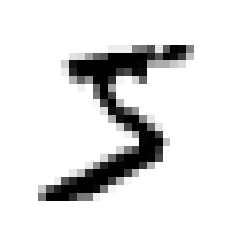

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0, :]
some_digit = np.array(some_digit)
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3-2. 이진 분류기 훈련
- 문제를 단순화하여 하나의 숫자를 식별하는 분류기를 만들어본다.
- 예를 들어 다음과 같은 '5-감지기'는 **'5'와 '5 아님' 2개의 클래스를 구분**할 수 있는 **이진 분류기**이다.
- 분류 작업을 위한 타겟 벡터를 만들고, 분류 모델을 하나 선택하여 훈련시켜 본다.
- 사이킷런의 **`SGDClassifier`** 클래스를 이용하여 **확률적 경사 하강법(SGD)** 분류기를 사용하면 매우 큰 데이터셋을 효율적으로 처리할 수 있다는 장점이 있다. SGD는 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문이다.
- **`SGDClassifier`** 모델을 만들고 전체 훈련 세트를 사용하여 훈련시킨다.
- 훈련시킨 모델을 사용에 **`predict`**를 이용하여 숫자 5의 이미지인지 예측한다.
- 이 분류기는 이미지가 5를 나타낸다(**True**)고 추측했다.

In [ ]:
# 값이 5면 True, 다른 숫자면 모두 False
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42) # SGDClassifier는 훈련하는데 무작위성을 사용하므로 결과를 재현하고 싶다면 random_state를 지정해야 한다,
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

### 3-3. 성능 측정
- 분류기 모델의 성능을 평가한다. 이를 위해 사용할 수 있는 성능 지표가 많다.

#### 1) **교차 검증**을 사용한 정확도 측정
- 교차 검증은 모델을 평가하는 좋은 방법이다. **`cross_val_score( )`** 함수로 폴드가 3개인 k-겹 교차 검증을 사용하여 SGDClassifier 모델을 평가한다. 
- **k-겹 교차 검증**은 훈련 세트를 k개의 폴드로 나누고, **각 폴드에 대해 예측을 만들고 평가**하기 위해 **나머지의 폴드로 훈련시킨 모델을 사용**하는 방식이다.
- 모든 교차 검증 폴드에 대하여 **정확도**(정확한 예측의 비율)가 95% 이상이다.
---
- 이번에는 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교한다. 이 분류기는 예측값으로 5가 아니라는 의미의 False인 0을 반환한다.
- 정확도가 90% 이상으로 나온다. 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90% 너무나도 뛰어난 예측 정확도를 보인다.
---
- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다.
- 특히 어떤 클래스가 다른 것보다 월등하게 많은 불균형한 데이터셋을 다룰 때 더욱 그렇다.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # 모든 예측값으로 False인 0을 반환

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 3-3. 성능측정
#### 2) **오차 행렬**
- 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것이다.
- 오차 행렬을 만드려면 **실제 타겟값과 비교**할 수 있도록 **먼저 예측값**을 만들어야 한다. **테스트 세트**로 예측할 수 있지만 분류기가 출시 준비를 마친 후 마지막에 사용하기 위해 여기서는 **사용하지 않는다**. 대신 훈련 세트에 **`cross_val_predict( )`** 함수를 사용한다.
- **`cross_val_predict( )`** 함수는 `cross_val_score( )` 함수처럼 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고, **각 테스트 폴드에서 얻은 예측값을 반환**한다. 즉 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다.
- 예측값을 구한 후 사이킷런의 `metrics`로부터 **`confusion_matrix`**를 임포트하여 오차 행렬을 만든다. 타겟 클래스인 y_train_5와 예측 클래스인 y_train_pred를 넣고 호출하면 된다.
---
- 오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.
- 이 행렬의 첫번째 행은 '5 아님' 이미지(음성 클래스)에 대한 것으로 53892개를 '5 아님'으로 정확하게 분류(진짜 음성, **TN**)했고, 나머지 687개를 '5'라고 잘못 분류(**FP**)했다. 
- 두번째 행은 '5' 이미지(양성 클래스)에 대한 것으로 1891개를 '5 아님'으로 잘못 분류(**FN**)했고, 나머지 3530개를 정확히 '5'라고 분류(진짜 양성, **TP**)했다.

|                |     음성예측    |    양성예측    |
|:--:- | :---: | :---: | 
|    음성클래스   |       53892(TN)     |     687(FP)    |
|    양성클래스   |       1891(FN)     |      3530(TP)    |

- 완벽한 분류기라면 진짜 양성(TP)과 진짜 음성(TN)만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 된다.

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# 완벽한 분류기
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3-3. 성능측정
#### 2) **오차 행렬**
|                |     음성예측    |    양성예측    |
|:--:- | :---: | :---: | 
|    음성클래스   |       TN     |      FP    |
|    양성클래스   |       FN     |      TP    |

- 오차 행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요할 때가 있다.
- 살펴볼만한 것으로 분류기의 **정밀도**(precision)가 있는데, 이는 **양성 예측의 정확도**이다. **정밀도** = $\frac{TP}{TP+FP}$
- 확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만, 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 그리 유용하지 않다.
- 정밀도는 **재현율**(recall)이라는 또 다른 지표와 같이 사용하는 것이 일반적인데, 재현율은 **분류기가 정확하게 감지한 양성 샘플의 비율**을 의미하며 **민감도** 또는 **진짜 양성 비율**(TPR)이라고도 한다. **재현율** = $\frac{TP}{TP+FN}$

### 3-3. 성능 측정
#### 3) **정밀도**와 **재현율**
- 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.
- 사이킷런의 `metrics`로부터 정밀도는 **`precision_score`**, 재현율은 **`recall_score`**를 임포트하여 실제값과 예측값을 입력하여 사용한다.
- **정밀도와 재현율의 조화 평균**을 **F1 점수**라고 하는 하나의 숫자로 만들면 두 분류기를 비교할 때 편리하다. **F1 점수** = $2*\frac{정밀도*재현율}{정밀도+재현율}$
- 사이킷런의 `metrics`로부터 **`f1_score`**를 임포트하여 사용한다.
- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다. 하지만 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있으므로 F1 점수가 높다고 해서 항상 바람직한 것은 아니다.
- 정밀도와 재현율은 동시에 얻을 수 없다. 정밀도를 올리면 재현율이 줄어들고, 재현율을 올리면 정밀도가 줄어든다. 이를 **정밀도/재현율 트레이드오프**라고 한다.

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # 3530/(3530+687)
print(recall_score(y_train_5, y_train_pred)) # 3530/(3530+1891)

0.8370879772350012
0.6511713705958311


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3-3. 성능 측정
#### 4) **정밀도/재현율 트레이드오프**
- 트레이드오프 관계를 이해하기 위해 SGDClassifier가  분류를 어떻게 결정하는지 살펴본다. 이 분류기는 **결정 함수**를 사용하여 **각 샘플의 점수를 계산**하는데, 이 점수가 **임계값보다 크면** 샘플을 **양성** 클래스에 할당하고 **임계값보다 낮으면** 샘플을 **음성** 클래스에 할당한다.

(음성 예측) 8  7  3  9  5  2  5  |  5  6  5  5  5 (양성 예측)
- | 를 임계값으로 하여 예측했을 때, 정밀도는 양성으로 예측한 것 5개 중 4개이므로 80%이고 재현율은 실제 6개 중 4개이므로 67%이다.

(음성 예측) 8  7  3  9  5  2  5  5  6  |  5  5  5 (양성 예측)
- 임계값을 높인 | 로 예측했을 때, 정밀도는 양성으로 예측한 것 3개 중 3개이므로 100%로 높아지지만 재현율은 실제 6개 중 3개이므로 50%로 줄어든다.
---
- 사이킷런에서 임계값을 직접 지정할 수는 없지만, **예측에 사용한 점수는 확인**할 수 있다.
- 분류기의 **`predict( )`** 메서드 대신에 **`decision_function( )`** 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다. 이 점수를 기반으로 하여 원하는 임계값을 정해 예측을 만들 수 있다.
- SGDClassifier의 임계값이 0이므로 임계값을 0으로 지정하면 `predict( )` 메서드와 같은 결과를 반환한다. 
- 그러나 임계값을 8000으로 높이면 실제 5인 이미지를 분류기가 감지하지 못하므로 재현율이 줄어든다.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

# 임계값을 0으로 지정
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

In [ ]:
# 임계값을 8000으로 지정
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### 3-3. 성능 측정
#### 4) 정밀도/재현율 트레이드오프
- 적절한 임계값을 정하기 위해서는 먼저 **`cross_val_predict( )`** 함수를 사용하여 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다. 이때 옵션에 예측값이 아닌 **결정 점수를 반환**받도록 **`method="decision_function"`**을 지정한다.
- 이 점수로 **`precision_recall_curve( )`** 함수를 사용하여 가능한 **모든 임계값에 대하여 정밀도와 재현율을 계산**할 수 있다.
- `matplotlib`을 이용해 임계값의 함수로 정밀도와 재현율을 그릴 수 있다.

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

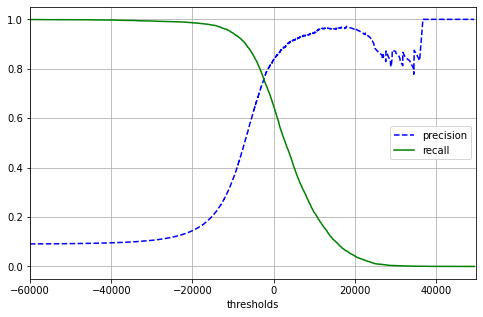

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.legend()
    plt.xlabel("thresholds")
    plt.xlim(-60000, 50000)
    plt.grid()
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

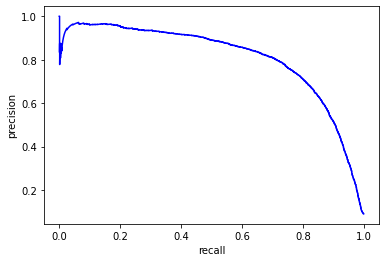

In [ ]:
plt.plot(recalls, precisions, "b")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

### 3-3. 성능 측정
#### 4) 정밀도/재현율 트레이드오프
- 정밀도가 급격하게 줄어드는 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.
- 만약 정밀도 90%를 달성하는 것이 목표라고 가정할 때, 임계값이 약 8000 정도라는 것을 알 수 있다. 
- **`np.argmax`**는 최댓값의 첫번째 인덱스를 반환한다. 이를 이용하여 좀 더 정확하게 최소한 90%의 정밀도가 되는 가장 낮은 임계값을 찾을 수 있다.
- 이렇게 구한 임계값보다 더 큰 값을 가지면 '5'로, 더 낮은 값을 가지면 '5 아님'으로 분류한다.
- 실제값과 예측값에 대해 정밀도를 구해보면 90%의 정밀도를 달성했음을 확인할 수 있다.

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### 3-3. 성능 측정
#### 5) **ROC 곡선**
- ROC(수신기 조작 특성) 곡선도 이진 분류에서 널리 사용하는 도구로, **거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율)**의 곡선이다.
- FPR은 양성으로 잘못 분류된 음성 샘플의 비율이며, 1에서 정확하게 분류한 음성 샘플의 비율(TNR)을 뺀 값이다. 진짜 음성 비율인 TNR을 **특이도**라고도 한다.
- 따라서 ROC곡선은 **1-특이도에 대한 재현율 곡선**이다.
- ROC 곡선을 그리려면 먼저 **`roc_curve( )`**를 이용하여 여러 임계값에서 FPR과 TPR을 계산해야 한다. **`roc_curve( )`**는 인자로 레이블과 점수를 입력받는다.
- 그 다음에 `matplotlib`을 사용하여 FPR에 대한 TPR 곡선을 나타낼 수 있다.
- ROC 곡선에도 트레이드오프가 존재하는데 재현율인 TPR이 높을수록 분류기가 만드는 거짓 양성 비율인 FPR이 증가한다. 
- 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻하며, 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다.

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

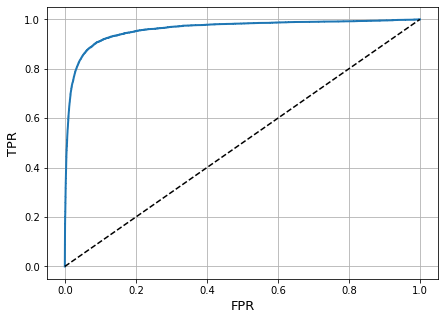

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.grid()
    plt.xlabel("FPR", fontsize=13)
    plt.ylabel("TPR", fontsize=13)

plot_roc_curve(fpr, tpr)
plt.show()

### 3-3. 성능 측정
#### 5) ROC 곡선
- **ROC 곡선 아래의 면적**을 나타내는 **AUC**를 측정하면 분류기들을 비교할 수 있다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 ROC의 AUC가 0.5이다.
- 사이릿런의 `metrics`로부터 **`roc_auc_score`**를 임포트하여 ROC의 AUC를 계산할 수 있다.
---
- RandomForestClassifier를 훈련시켜서 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교한다. 
- 먼저 **`cross_val_predict( )`** 함수를 사용하여 훈련 세트에 있는 모든 샘플의 점수를 구해야 하는데, RandomForestClassifier는 `decision_function( )` 메서드가 없는 대신 **`predict_proba( )`** 메서드를 가지고 있다. 옵션으로 **`method="predict_proba"`**를 지정한다.
- 사이킷런 분류기는 일반적으로 이 두개의 메서드 중 하나 또는 둘 모두를 가지고 있다. **`predict_proba( )`**는 샘플이 행, 클래스가 열이고 **샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환**한다. 
- `roc_curve( )` 함수는 인자로 레이블과 점수를 기대하지만, 점수 대신에 **클래스 확률**을 전달할 수 있다. 
- 양성 클래스 확률을 점수로 사용하여 ROC 곡선을 그린다.
- 그림에서 볼 수 있듯이 RandomForestClassifier의 ROC 곡선이 SGDClassifier의 ROC 곡선보다 왼쪽 위 모서리에 더 가까이 위치하여 RandomForestClassifier가 더 좋은 분류기라는 것을 알 수 있다. 당연히 ROC AUC 점수도 RandomForestClassifier가 0.9983으로 SGDClassifier의 0.9604보다 더 높다.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [ ]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# 양성 클래스에 대한 확률
y_scores_forest = y_probas_forest[:, 1]

In [ ]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

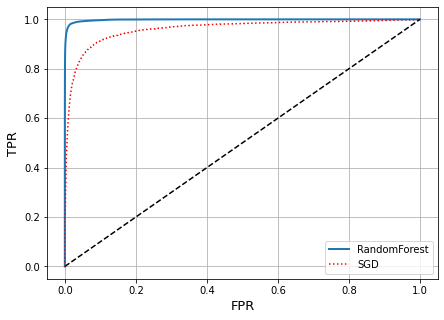

In [ ]:
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.plot(fpr, tpr, "r:", label="SGD")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 3-4. 다중 분류
- 이진 분류가 2개의 클래스를 구별하는 반면, **다중 분류기** 또는 **다항 분류기**는 **둘 이상의 클래스를 구별**할 수 있다.
- SGD, 랜덤 포레스트, 나이브 베이즈 등의 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, 로지스틱 회귀나 서포트 벡터 머신과 같은 알고리즘은 이진 분류만 가능하다.
- 하지만 이진 분류기를 여러개 사용하여 다중 클래스를 분류하는 기법도 많다.
- 예를 들어 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다. 
- 이미지를 분류할 때 **각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택**하면 되는데 이를 **OvR**(one-versus-the-rest) 전략, 또는 **OvA**(one-versus-all) 전략이라고 한다.
- 또 다른 전략은 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 **각 숫자의 조합마다 이진 분류기를 훈련시키는 방법**으로 **OvO**(one-versus-one) 전략이라고 한다. 클래스가 N개라면 분류기는 $N*(N-1)/2$개가 필요하다. 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 장점이 있다.
- 서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트 크기에 민감하여 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빨라 OvO를 선호하지만, 대부분의 이진 분류 알고리즘에서는 OvR을 선호한다.
- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다.

### 3-4. 다중 분류
- 사이킷런의 `svm`으로부터 **`SVC`**를 임포트하여 서포트 벡터 머신 분류기를 테스트한다.
- 다음 코드는 5를 구별한 타겟 클래스인 y_train_5 대신 0에서 9까지의 원래 타겟 클래스 y_train을 사용하여 SVC를 훈련시킨다. 그리고 predict로 예측값을 만든다.
- 내부에서는 사이킷런이 **OvO 전략**을 사용하여 10개의 이진 분류기를 훈련시키고 **각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택**한다.
- **`decision_function( )`** 메서드를 호출하면 **하나의 샘플당 10개의 점수를 반환**하며, 이 **점수는 각 클래스마다 하나씩**이다.
- 가장 높은 점수가 클래스 5에 해당하는 값이다.

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
print(np.argmax(some_digit_scores))
svm_clf.classes_

5


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### 3-4. 다중 분류
- 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 사이킷런의 `multiclass`로부터 **OneVsOneClassifier**나 **OneVsRestClassifier**를 임포트하여 사용한다.
- 간단하게 이진 분류기 인스턴스를 만들고, 객체를 생성할 때 전달하는 방식이다.
---
- SGDClassifier 또는 RandomForestClassifier를 훈련시키는 것도 간단하다.
- 이 경우 SGD 분류기는 **직접 샘플을 다중 클래스로 분류**할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없다.
- **`decision_function( )`** 메서드를 클래스마다 하나의 값을 반환한다. SGD 분류기가 클래스마다 부여한 점수를 확인한다.
- 대부분의 점수가 큰 음수인 반면 클래스 3의 점수는 1823.73로, 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있다. 
---
- 분류기를 평가하기 위해서는 일반적으로 교차 검증을 사용한다.
- **`cross_val_score( )`** 함수를 사용하여 SGDClassifier의 정확도를 평가한다.
- 모든 테스트 폴드에서 84% 이상의 정확도를 얻었다. 
- 이 점수가 아주 나쁘지는 않지만 성능을 더 높일 여지가 있다. 예를 들어 간단하게 입력의 스케일을 조정하여 정확도를 89% 이상으로 더 높일 수 있다.

In [ ]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 생성
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
print(len(ovr_clf.estimators_))

10


In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### 3-5. 에러 분석
- 실제 프로젝트라면 데이터 준비 단계에서 가능한 선택 사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라 GridSearchCV를 사용하여 하이퍼파라미터를 세밀하게 튜닝하고, 앞에서 한 것처럼 가능한 한 자동화한다.
- 여기서는 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아본다. SGDClassifier 분류기를 사용한다.
- 한가지 방법은 만들어진 에러의 종류를 분석하는 것이다.
- 먼저 오차 행렬을 살펴볼 수 있다. **`cross_val_predict( )`** 함수를 사용하여 예측을 만들고 **`confusion_matrix( )`** 함수를 호출한다.
- 많은 숫자가 출력되므로 오차 행렬을 `matplotlib`의 **`matshow( )`** 함수를 사용하여 이미지로 표현하면 보기에 더 편리하다.
- 이 오차 행렬은 대부분의 이미지가 **올바르게 분류되었음을 나타내는 주대각선**에 있으므로 매우 좋아보인다. 
- 배열에서 **가장 큰 값은 흰색**으로, **가장 작은 값은 검은색**으로 정규화되어 그려진다. 숫자 5는 다른 숫자보다 조금 더 어두워 보이는데, 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 것을 의미한다.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

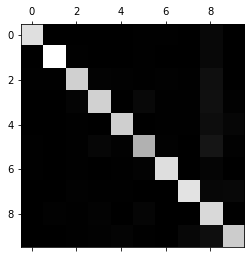

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

### 3-5. 에러 분석
- 그래프의 에러 부분에 초점을 맞춰본다. 먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 **에러 비율을 비교**한다.
- 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그린다.
- 여기서 분류기가 만든 에러를 확실히 볼 수 있다. 오차 행렬의 행은 실제 클래스를 나타내고, 열은 예측한 클래스를 나타낸다. 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시한다. 그러나 클래스 8의 행은 그리 나쁘지 않으므로 이는 실제 8이 적절하게 8로 분류되었다는 것을 의미한다. 이렇듯 오차 행렬이 반드시 대칭인 것은 아니다.
- 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다. 이 그래프를 살펴보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다. 예를 들어 8처럼 보이지만 실제 8은 아닌 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분할 수 있도록 분류기를 학습시킬 수 있다. 
- 또는 분류기에 도움이 될 만한 특성을 더 찾아볼 수 있는데 예를 들어 동심원의 수를 세는 알고리즘 같은 것이다, 또는 동심원 같은 어떤 패턴이 드러나도록 Scikit-Image, Pillow, OpenCV 등을 사용하여 이미지를 전처리해볼 수 있다.
- 개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있지만 더 어렵고 오랜 시간이 걸린다.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

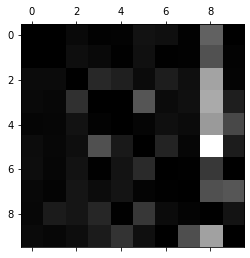

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### 3-6. 다중 레이블 분류
- 지금까지는 각 샘플이 하나의 클래스에 할당되었지만, 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있다.
- 예를 들어 얼굴 인식 분류기가 존재할 때, 같은 사진에 여러 사람이 등장한다면 인식된 사람마다 하나씩 꼬리표를 붙여야 한다. 분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되었다고 가정할 때, 앨리스와 찰리가 있는 사진을 본다면 [1, 0, 1] 을 출력해야 한다.
- 이처럼 **여러 개의 이진 꼬리표를 출력**하는 분류 시스템을 **다중 레이블 분류** 시스템이라고 한다.
---
- 다음 코드는 각 숫자 이미지에 2개의 타겟 레이블이 담긴 y_multilabel 배열을 만든다. 첫번째는 숫자가 큰 값인 7, 8, 9인지를 나타내고 두번째는 홀수인지를 나타낸다.
- 그 다음 **KNeighborsClassifier** 인스턴스를 만들고 앞서 생성한 다중 타겟 배열을 사용하여 훈련시킨다. KNeighborsClassifier는 다중 레이블 분류를 지원하지만 모든 분류기가 그런 것은 아니다.
- 훈련시킨 분류기에 `predict`를 이용하여 예측을 만들면 레이블이 2개 출력된다.
- 해당하는 숫자 5는 7, 8,9에 해당하지 않으므로 첫번째는 False고, 홀수이므로 두번째는 True이다. 올바르게 분류된 것을 확인할 수 있다.

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

### 3-6. 다중 레이블 분류
- 다중 레이블 분류기를 평가하는 방법은 많으나 적절한 지표는 프로젝트에 따라 다르다.
- 예를 들어 각 레이블의 F1 점수를 구하고 간단하게 평균 점수를 계산할 수 있다. 다음 코드는 모든 레이블에 대한 F1 점수의 평균을 계산한다.
- 실제로는 아닐 수 있지만 이 코드는 모든 레이블의 가중치가 같다고 가정한 것이다.
- 만약 **특정 클래스의 데이터가 훨씬 많다면** 그 클래스의 데이터에 대한 **분류기의 점수에 더 높은 가중치**를 둘 것이다. 간단한 방법은 **레이블에 클래스의 지지도를 가중치**로 주는 것이다. 옵션을 **`average='weighted'`**로 지정하면 된다.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

### 3-7. 다중 출력 분류
- 다중 레이블 분류에서 **한 레이블이 다중 클래스가 될 수 있도록 일반화**할 수 있다. 즉 값을 2개 이상 가질 수 있는 것이다. 이를 다중 출력 다중 클래스 분류, 간단히 **다중 출력 분류**라고 한다.
- 이를 위해서 이미지에서 잡음을 제거하는 시스템을 만든다. 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력한다.
- 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고, 각 레이블은 0부터 255까지의 픽셀 강도로 여러 개의 값을 가지므로 다중 출력 분류 시스템이다.
- 먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 `randint( )` 함수를 사용하여 픽셀 강도에 잡음을 추가한다. 타겟 이미지는 원본 이미지가 될 것이다.
- 이제 분류기를 훈련시켜 이 이미지를 깨끗하게 만든다. 

In [ ]:
# 원본 이미지에 랜덤하게 생성한 잡음을 추가한 잡음 이미지를 생성
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# 원본 이미지를 타겟 이미지를 사용
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()